# Import needed libraries

In [181]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.book import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 60, 30
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
import warnings
warnings.filterwarnings("ignore")

# Data preparation

### Read data from JSON

Read data from one file - dutch1.json and display it in pandas DataFrame

In [154]:
# Read data from the file
path = 'C:/Users/ivan1/Downloads/candidate_test/DS_test/dutch_data/dutch1.json'
with open(path, 'r') as f:
    data = json.loads(f.read())
# Create DataFrame
df = pd.DataFrame(data)
# Display data example from DataFrame
df.head()

,author_avatar_url,author_gender,author_location,author_name,author_url,author_username,batch_name,brands,categories,content,...,posted_at,relevance_2,sentiment,source,source_domain,source_type,source_url,topics,url,who_curated
0,,,,,http://youtube.com/channel/UClPonqYvdo_XD7m533...,Peter R. de Vries,Seeds_DUTCH_1-1,,,Onderzoek moord Endstra\nKlippen\nHet onderzoe...,...,Sun Apr 23 15:35:14 2017,no,,youtube,www.youtube.com,video,http://www.youtube.com/,,https://www.youtube.com/watch?v=DVUjqOxn2SE,Brechtje
1,,,,,http://youtube.com/channel/UCtVRhmseKQa2DcQnMl...,Pphvideo,Seeds_DUTCH_1-1,,,Een dorsmachine wordt gebruikt voor het dorsen...,...,Wed Sep 21 17:53:52 2016,yes,neutral,youtube,www.youtube.com,video,http://www.youtube.com/,,https://www.youtube.com/watch?v=2FYB25e0_4E,Brechtje
2,,,,,,tuinvrouw agnes,Seeds_DUTCH_1-1,,,"De plant groeit vanuit een flinke bol,eerst on...",...,Mon Sep 19 22:09:01 2016,yes,neutral,tuin den horst,blog.seniorennet.be,blog,http://blog.seniorennet.be/tuindenhorst/,,http://blog.seniorennet.be/tuindenhorst/archie...,Brechtje
3,,,,,,Marja van Spaandonk,Seeds_DUTCH_1-1,,,Sommige planten verdwijnen gewoon\nFoto Taco v...,...,Sat Jul 23 13:30:25 2016,no,,Leidsch Dagblad,www.leidschdagblad.nl,news,http://www.leidschdagblad.nl,,http://www.leidschdagblad.nl/thema/mens/articl...,Brechtje
4,,,,,,,Seeds_DUTCH_1-1,,,Het is wetenschappelijk bewezen dat een slaapt...,...,Tue Jan 17 14:06:04 2017,no,,www.gezondheidsnet.nl,www.gezondheidsnet.nl,news,http://www.gezondheidsnet.nl,,https://www.gezondheidsnet.nl/overgewicht-en-a...,Brechtje


In [155]:
# Define DataFrame shape
df.shape

(5200, 25)

We have an additional 3 files. Read those files and add data to "df" DataFrame

In [156]:
files = ['dutch2', 'dutch3', 'dutch4']
for file in files:
    path = f'C:/Users/ivan1/Downloads/candidate_test/DS_test/dutch_data/{file}.json'
    with open(path, 'r') as f:
        data_file = json.loads(f.read())
        df_file = pd.DataFrame(data_file)
        df = pd.merge(df, df_file, how='outer')

In [157]:
# Define shape for the whole DataFrame
df.shape

(18000, 70)

### Data preparation

As we see there were 25 attributes from the first file and 70 from all four files. So, attributes for each file might be different

Useful data for us are only in columns "content" and "sentiment"
- "content" is a text of the review
- "sentiment" is a label of the review

In [158]:
# Create the DataFrame that consist of only "content" and "sentiment" columns
df = df[['content', 'sentiment']]
# Check the shape
df.shape

(18000, 2)

In [159]:
# Display the example of data
df.head()

,content,sentiment
0,Onderzoek moord Endstra\nKlippen\nHet onderzoe...,
1,Een dorsmachine wordt gebruikt voor het dorsen...,neutral
2,"De plant groeit vanuit een flinke bol,eerst on...",neutral
3,Sommige planten verdwijnen gewoon\nFoto Taco v...,
4,Het is wetenschappelijk bewezen dat een slaapt...,


We see that there are lots of empty values for "sentiment". Objects with empty "sentiment" do not give us any value
Clear the DataSet from empty values

In [160]:
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(3314, 2)

Define the amount of objects related to each sentiment

In [161]:
df['sentiment'].value_counts()

neutral     2228
positive     759
negative     179
not sure     148
Name: sentiment, dtype: int64

"not sure" sentiment does not give us any value. Exclude objects with "not sure" sentiment

In [162]:
df = df[df['sentiment']!='not sure']
df.shape

(3166, 2)

##### Conclusion: 
##### On the beginning, we have 18 000 objects. But only 3166 objects give as some value for sentimental analysis

# (1) Explore the dataset

### 1.1 - Concatenate all the text for each sentiment

In [163]:
# Exclude not needed symbols from "content"
df['content'] = df['content'].replace('[^a-zA-Z0-9]', ' ', regex = True)
# Use lower register from "content"
df['content'] = df['content'].str.lower()

In [164]:
df.head()

,content,sentiment
1,een dorsmachine wordt gebruikt voor het dorsen...,neutral
2,de plant groeit vanuit een flinke bol eerst on...,neutral
6,als de temperatuur boven het vriespunt komt k...,neutral
7,wie zijn er nog meer aanwezig lowieke van r...,neutral
8,tot slot nog een vooraanzicht van de hele kaps...,neutral


In [165]:
# Separate content for each sentiment
text_positive = df['content'][df['sentiment'] == 'positive']
text_negative = df['content'][df['sentiment'] == 'negative']
text_neutral = df['content'][df['sentiment'] == 'neutral']
# Concatenate words for each sentiment
positive_words = np.concatenate(text_positive.apply(lambda s: s.strip().split()).values)
negative_words = np.concatenate(text_negative.apply(lambda s: s.strip().split()).values)
neutral_words = np.concatenate(text_neutral.apply(lambda s: s.strip().split()).values)
# Define the number of words for each sentiment
print('Positive words:{}'.format(positive_words.size), '\nNegative words:{}'.format(negative_words.size), 
      '\nNeurtal words:{}'.format(neutral_words.size))

Positive words:26873 
Negative words:5438 
Neurtal words:80248


In [166]:
# Print the example of words for some sentiment
positive_words

array(['zelfs', 'met', 'een', ..., 'www', 'bijenisleven', 'nl'],
      dtype='<U31')

There are stop-words in the fords for each sentiment. Defined that language is Dutch. We should exclude Dutch stop-words from text

In [167]:
stop_words=set(stopwords.words('dutch'))
positive_words = [w for w in positive_words if not w in stop_words]
negative_words = [w for w in negative_words if not w in stop_words]
neutral_words = [w for w in neutral_words if not w in stop_words]
print('Positive words:{}'.format(len(positive_words)), '\nNegative words:{}'.format(len(negative_words)), 
      '\nNeurtal words:{}'.format(len(neutral_words)))

Positive words:16840 
Negative words:3625 
Neurtal words:51672


We decreased the number of words for each sentiment near 30% using stop-words

### 1.2 - Tokenize the text and the do a word frequency count of the words in all the text

In [168]:
# Tokenize words using sent_tokenize. Words are already tokenized, so this action might be extra 
positive_words_tock = sent_tokenize(str(positive_words))
negative_words_tock = sent_tokenize(str(negative_words))
neutral_words_tock = sent_tokenize(str(neutral_words))

In [169]:
# Define requency count of the words for each sentiment 
freqDist_positive = FreqDist(positive_words)
freqDist_negative = FreqDist(negative_words)
freqDist_neutral = FreqDist(neutral_words)

In [170]:
freqDist_positive, freqDist_negative, freqDist_neutral

(FreqDist({'planten': 426, 'https': 266, 't': 190, 'bloemen': 185, 'co': 183, 'tuin': 164, 'plant': 135, 'www': 135, 'nl': 129, 'we': 100, ...}),
 FreqDist({'gmo': 64, 'https': 56, 'planten': 46, 'nl': 45, 'http': 43, 't': 43, 'monsanto': 39, 'www': 38, 'co': 38, 'genetisch': 33, ...}),
 FreqDist({'planten': 944, 'https': 601, 'nl': 503, 't': 468, 'www': 467, 'http': 433, 'co': 425, 'bloemen': 339, 'plant': 337, 'gmo': 297, ...}))

### 1.3 - Do a plot of the word freq distribution for each of the classes

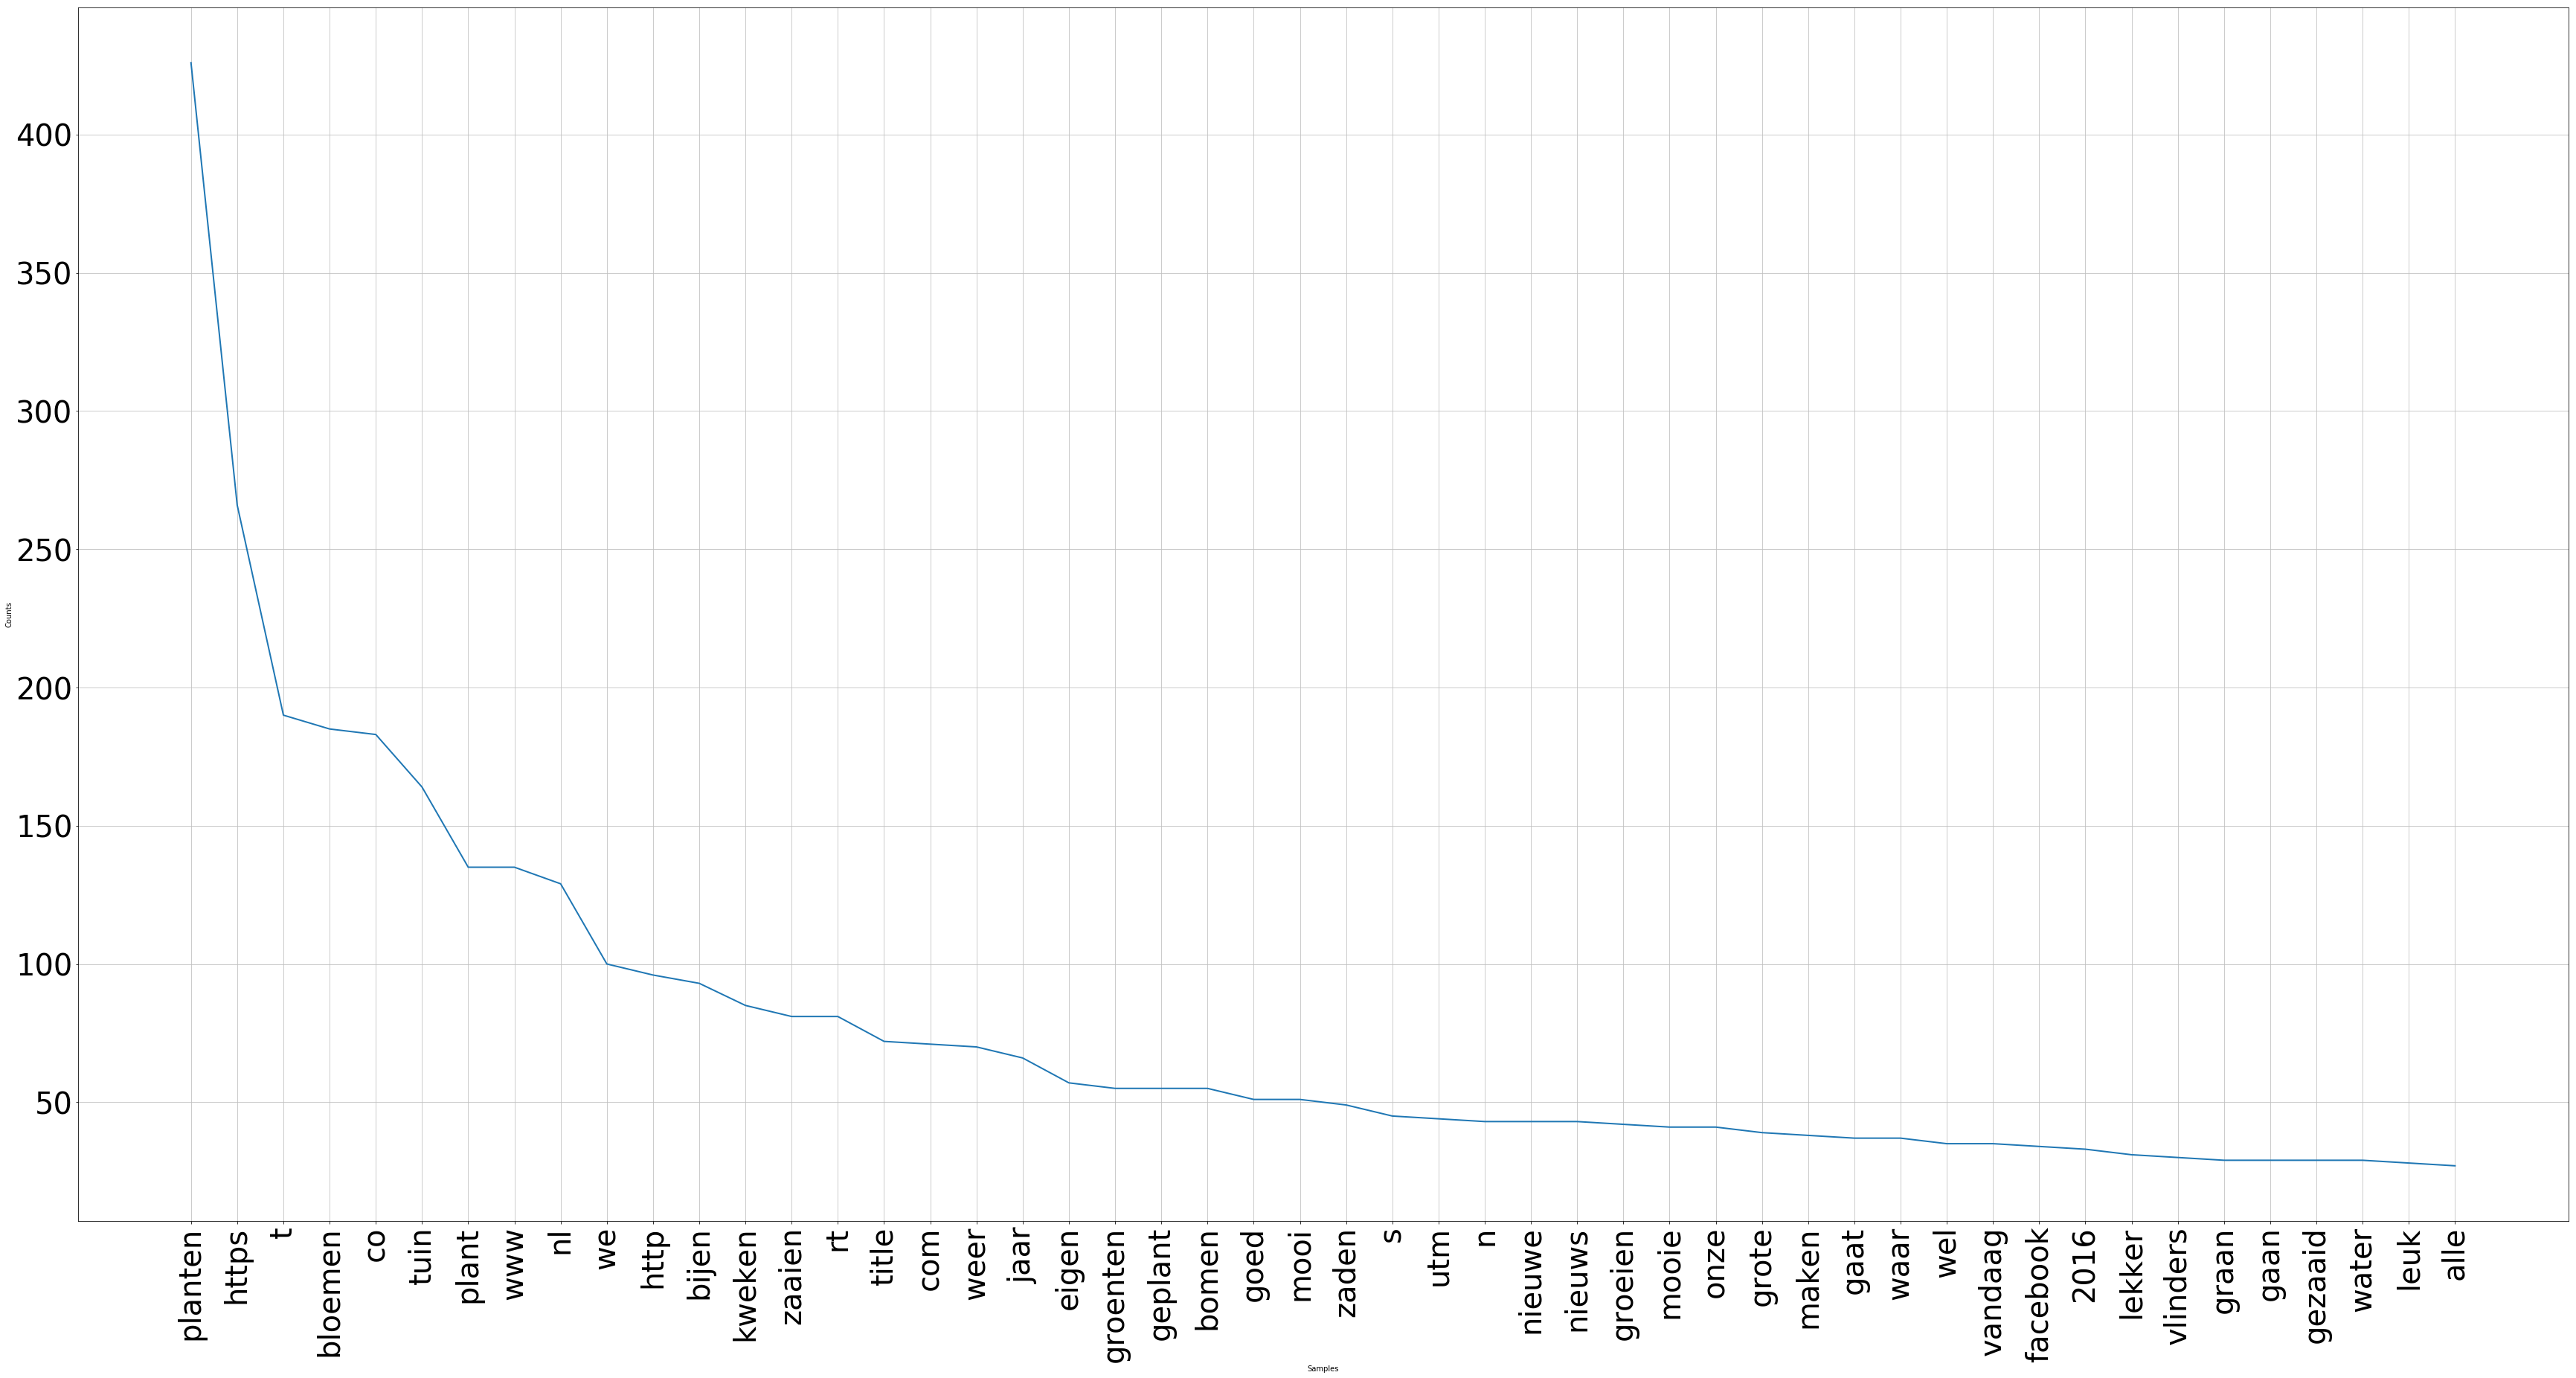

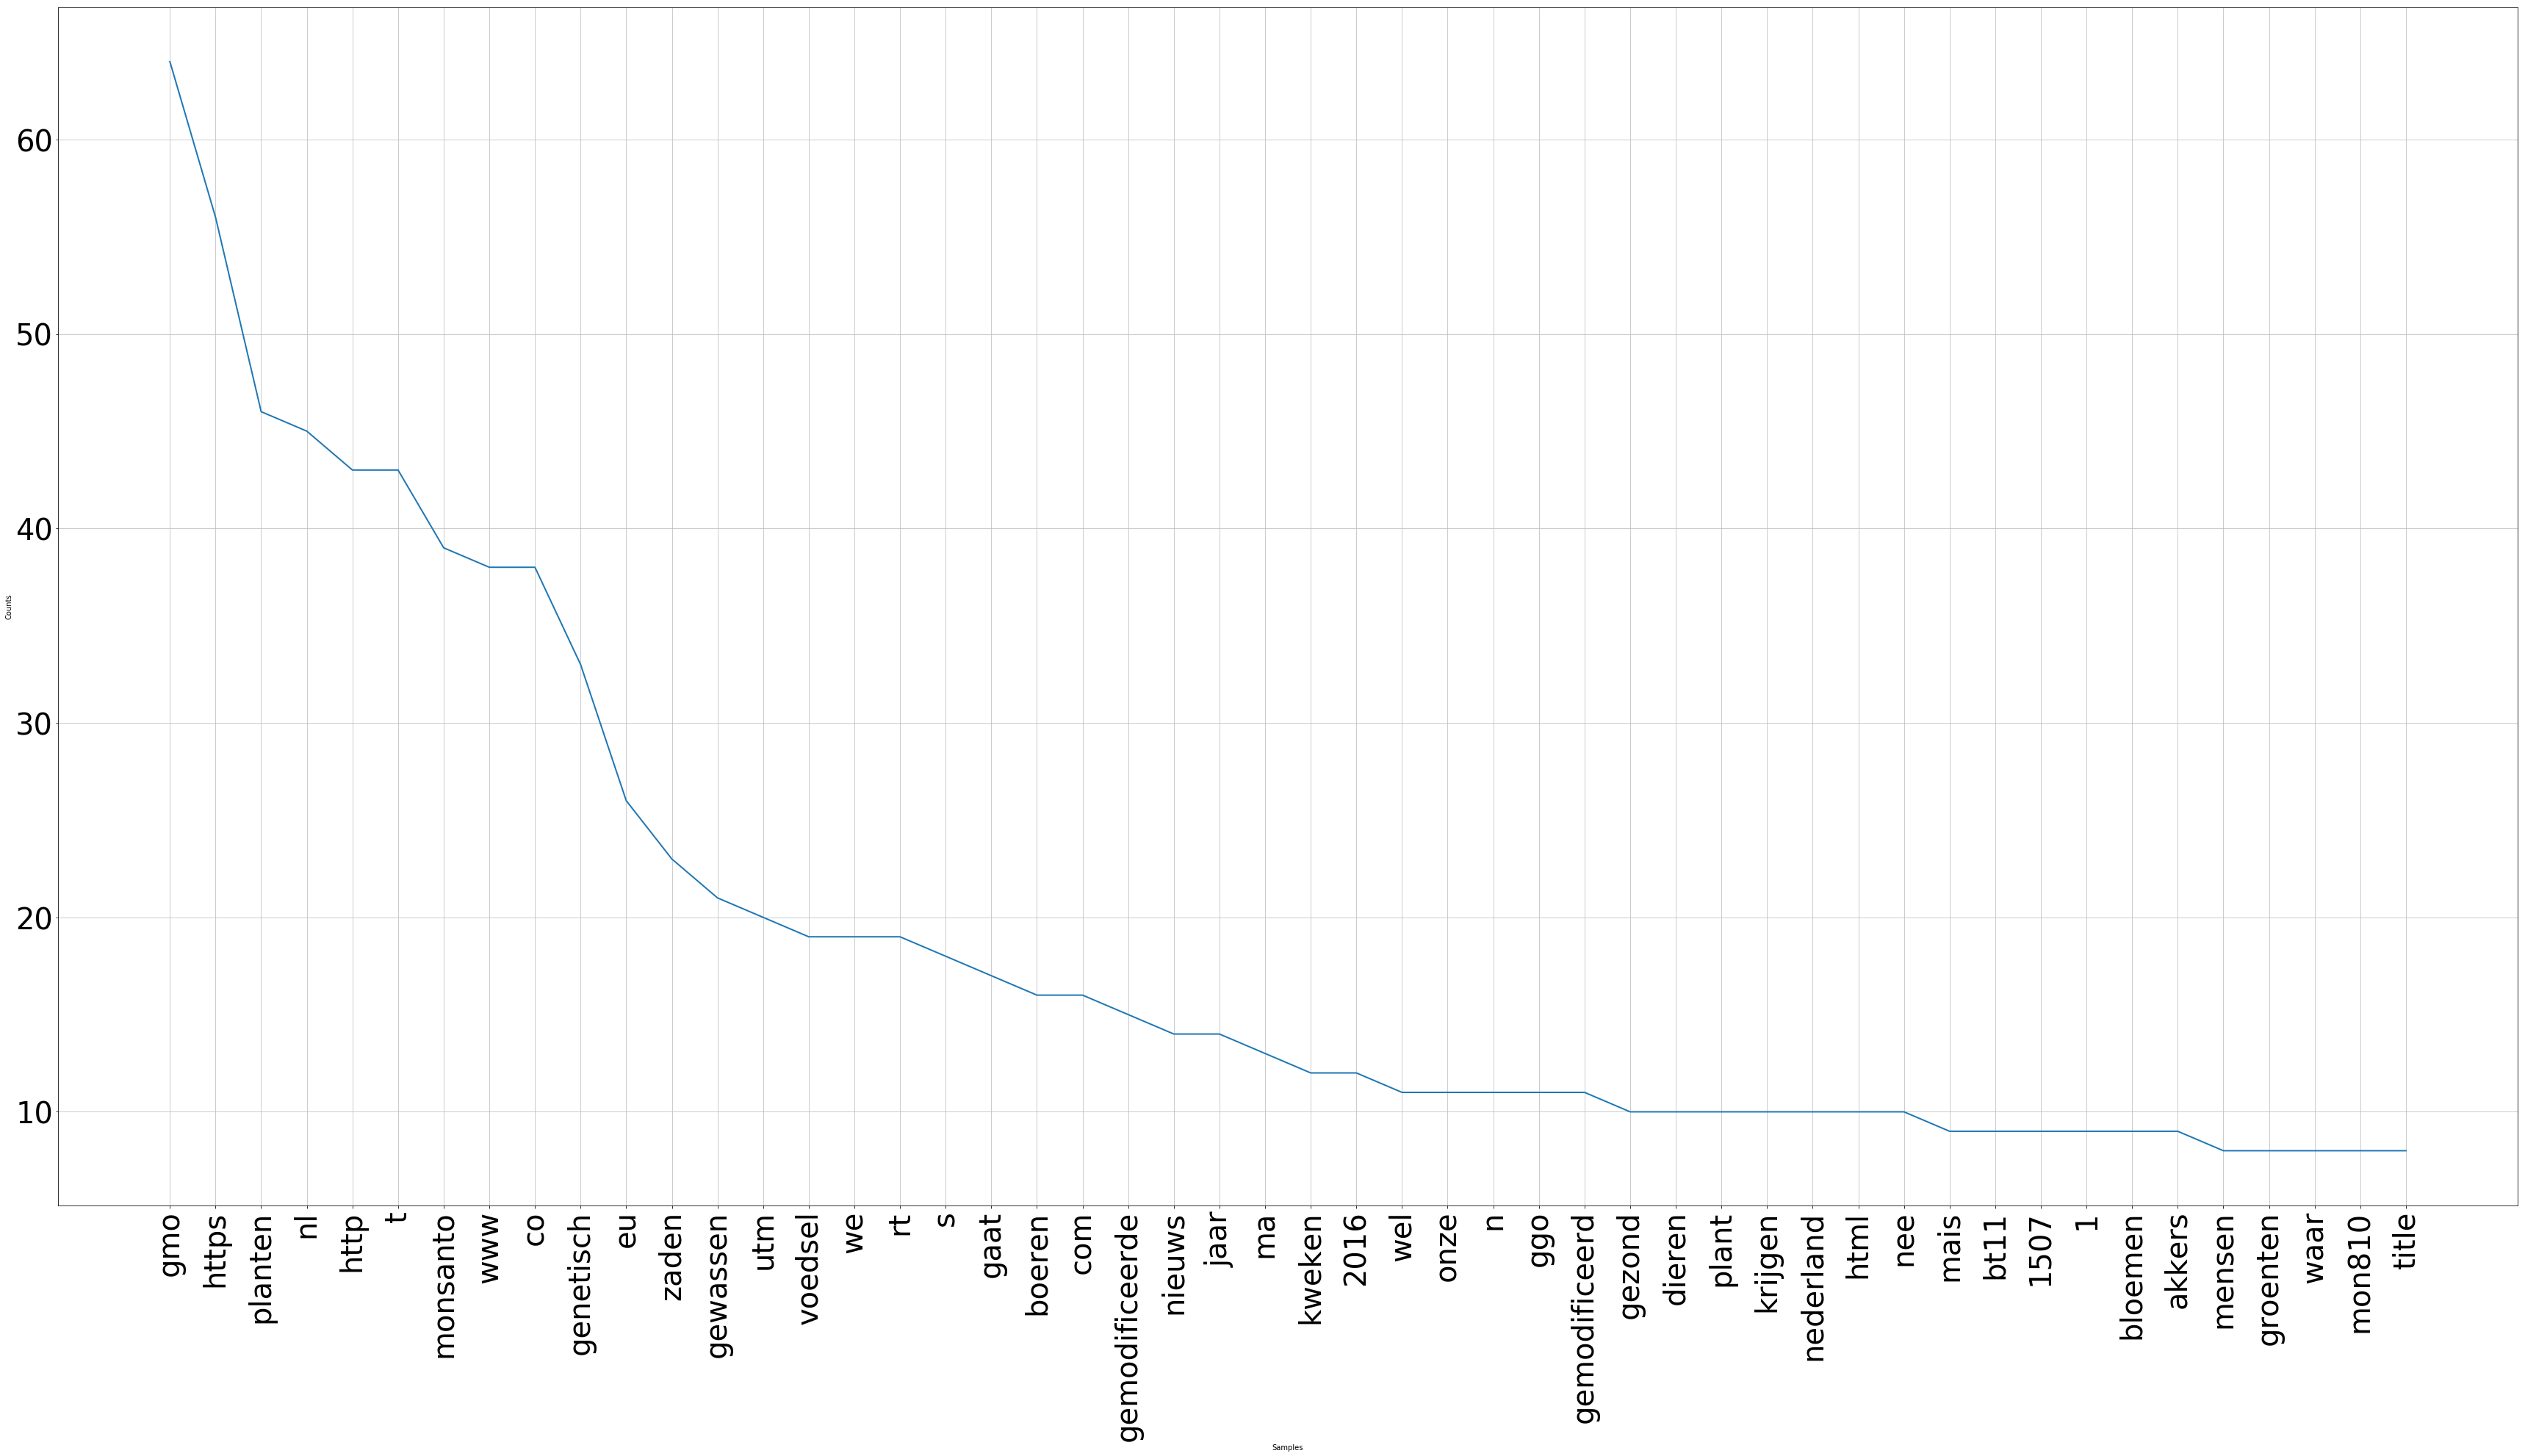

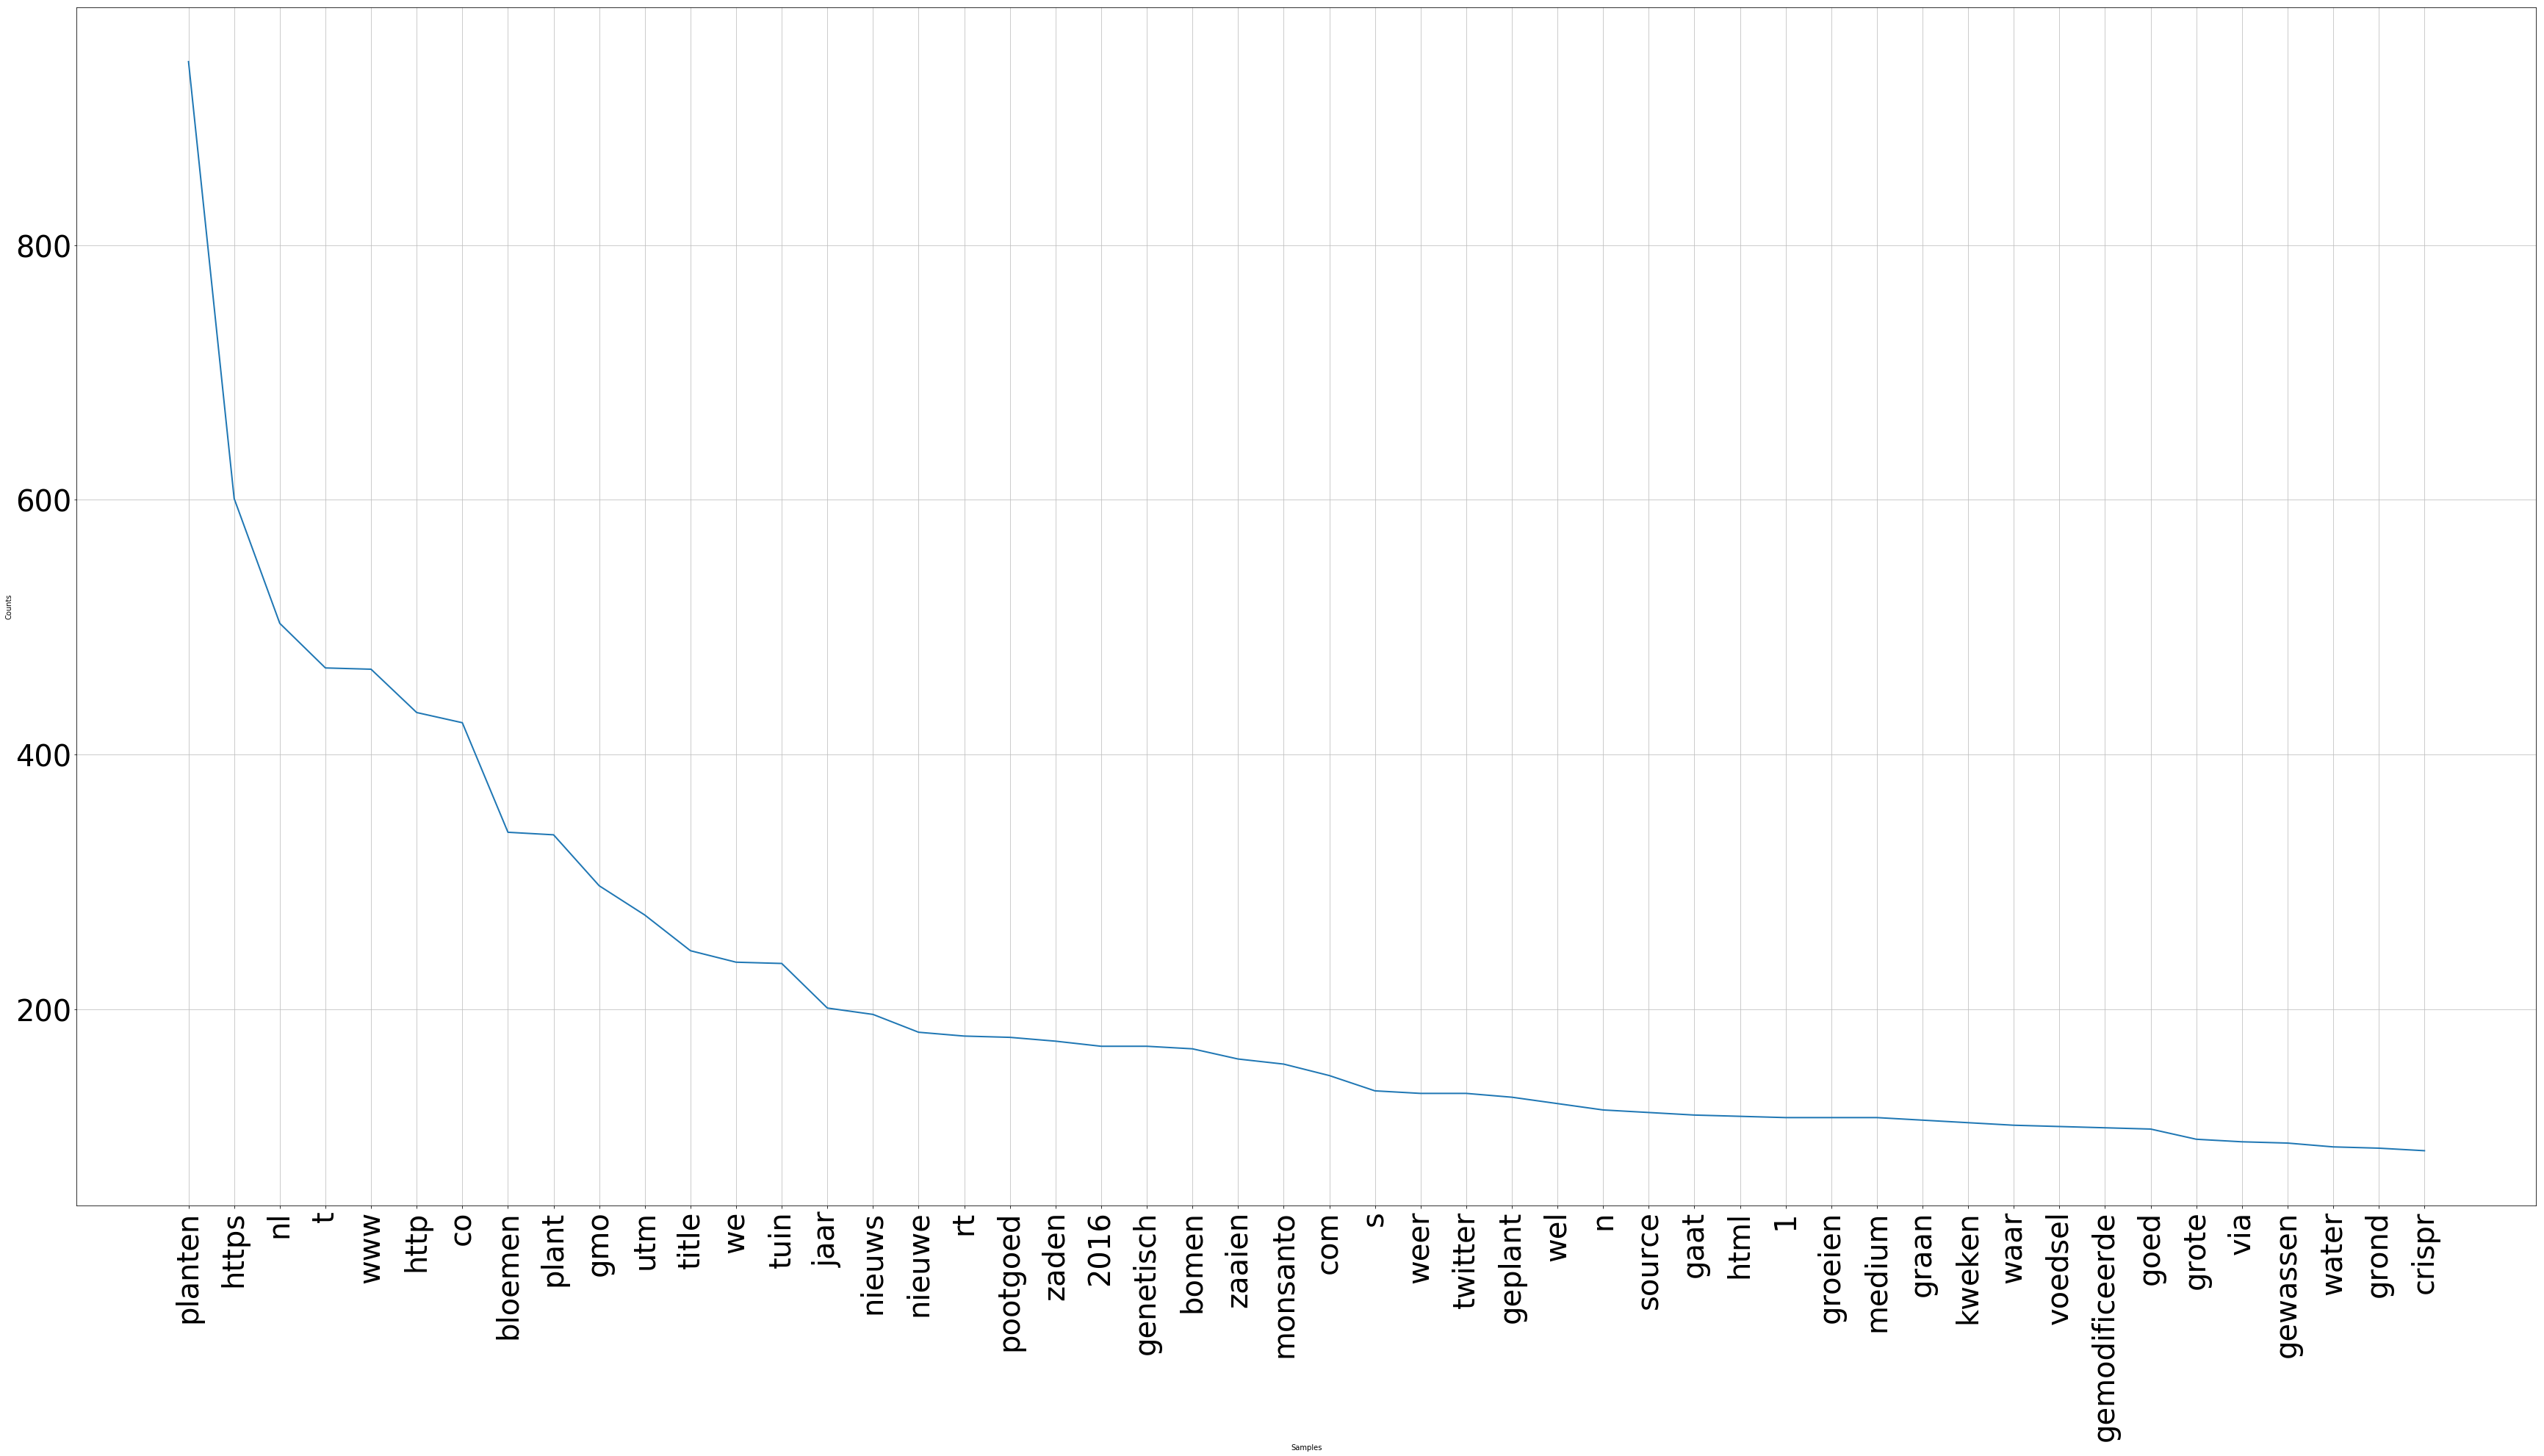

In [171]:
# Words distribution plot for each sentiment
freqDist_positive.plot(50)
freqDist_negative.plot(50)
freqDist_neutral.plot(50)

### 1.4 - Write out your thoughts about what words you think will be useful to have as features for the machine learning model to determine the sentiment of text and why

There are lots of words that repeat in each of sentiment. Those words can not help us to define sentiment. Those should be excluded. We should define the array intersections and exclude words with repeats in negative, neutral and positive sentiment.
Also, we see lots of words that do not give any value for the analysis. For example www, http, https, co and so on...
Ideally the best features are words that exist in the one sentiment and do not exist in another.  

Also, those features should repeat too often in the sentiment to have some value. Meaning that if the feature repeats lots of times it can be the feature for the sentiment. If it repeats one or two times, it might be some noise.  

In [172]:
# Define not intersected words for each sentiment
unic_positive = [i for i in positive_words if not (i in negative_words or i in neutral_words)]
unic_negative = [i for i in negative_words if not (i in positive_words or i in neutral_words)]
unic_neutral = [i for i in neutral_words if not (i in positive_words or i in negative_words)]
# Print some example of not intersected words
print('Unique positive words:{}'.format(unic_positive[:10]), '\nUnique negative words:{}'.format(unic_negative[:10]), 
      '\nUnique neutral words:{}'.format(unic_neutral[:10]))

Unique positive words:['ontspannen', 'slideshow', 'verzamel', 'zamelen', 'afvalcontainer', 'afvalzaadjes', 'toegestuurd', 'kerstmarkten', 'marja', 'verrijk'] 
Unique negative words:['oosten', 'basmati', 'punjab', 'tekortkomingen', 'sancties', 'afwezigheid', 'omtrent', 'voedselonveiligheidsproblemen', 'onvoldoende', 'gekwalificeerd'] 
Unique neutral words:['dorsmachine', 'dorsen', 'ofwel', 'rogge', 'zelfrijdende', 'dorsers', 'aangedreven', 'tractor', 'bloemstengels', 'kelkvormige']


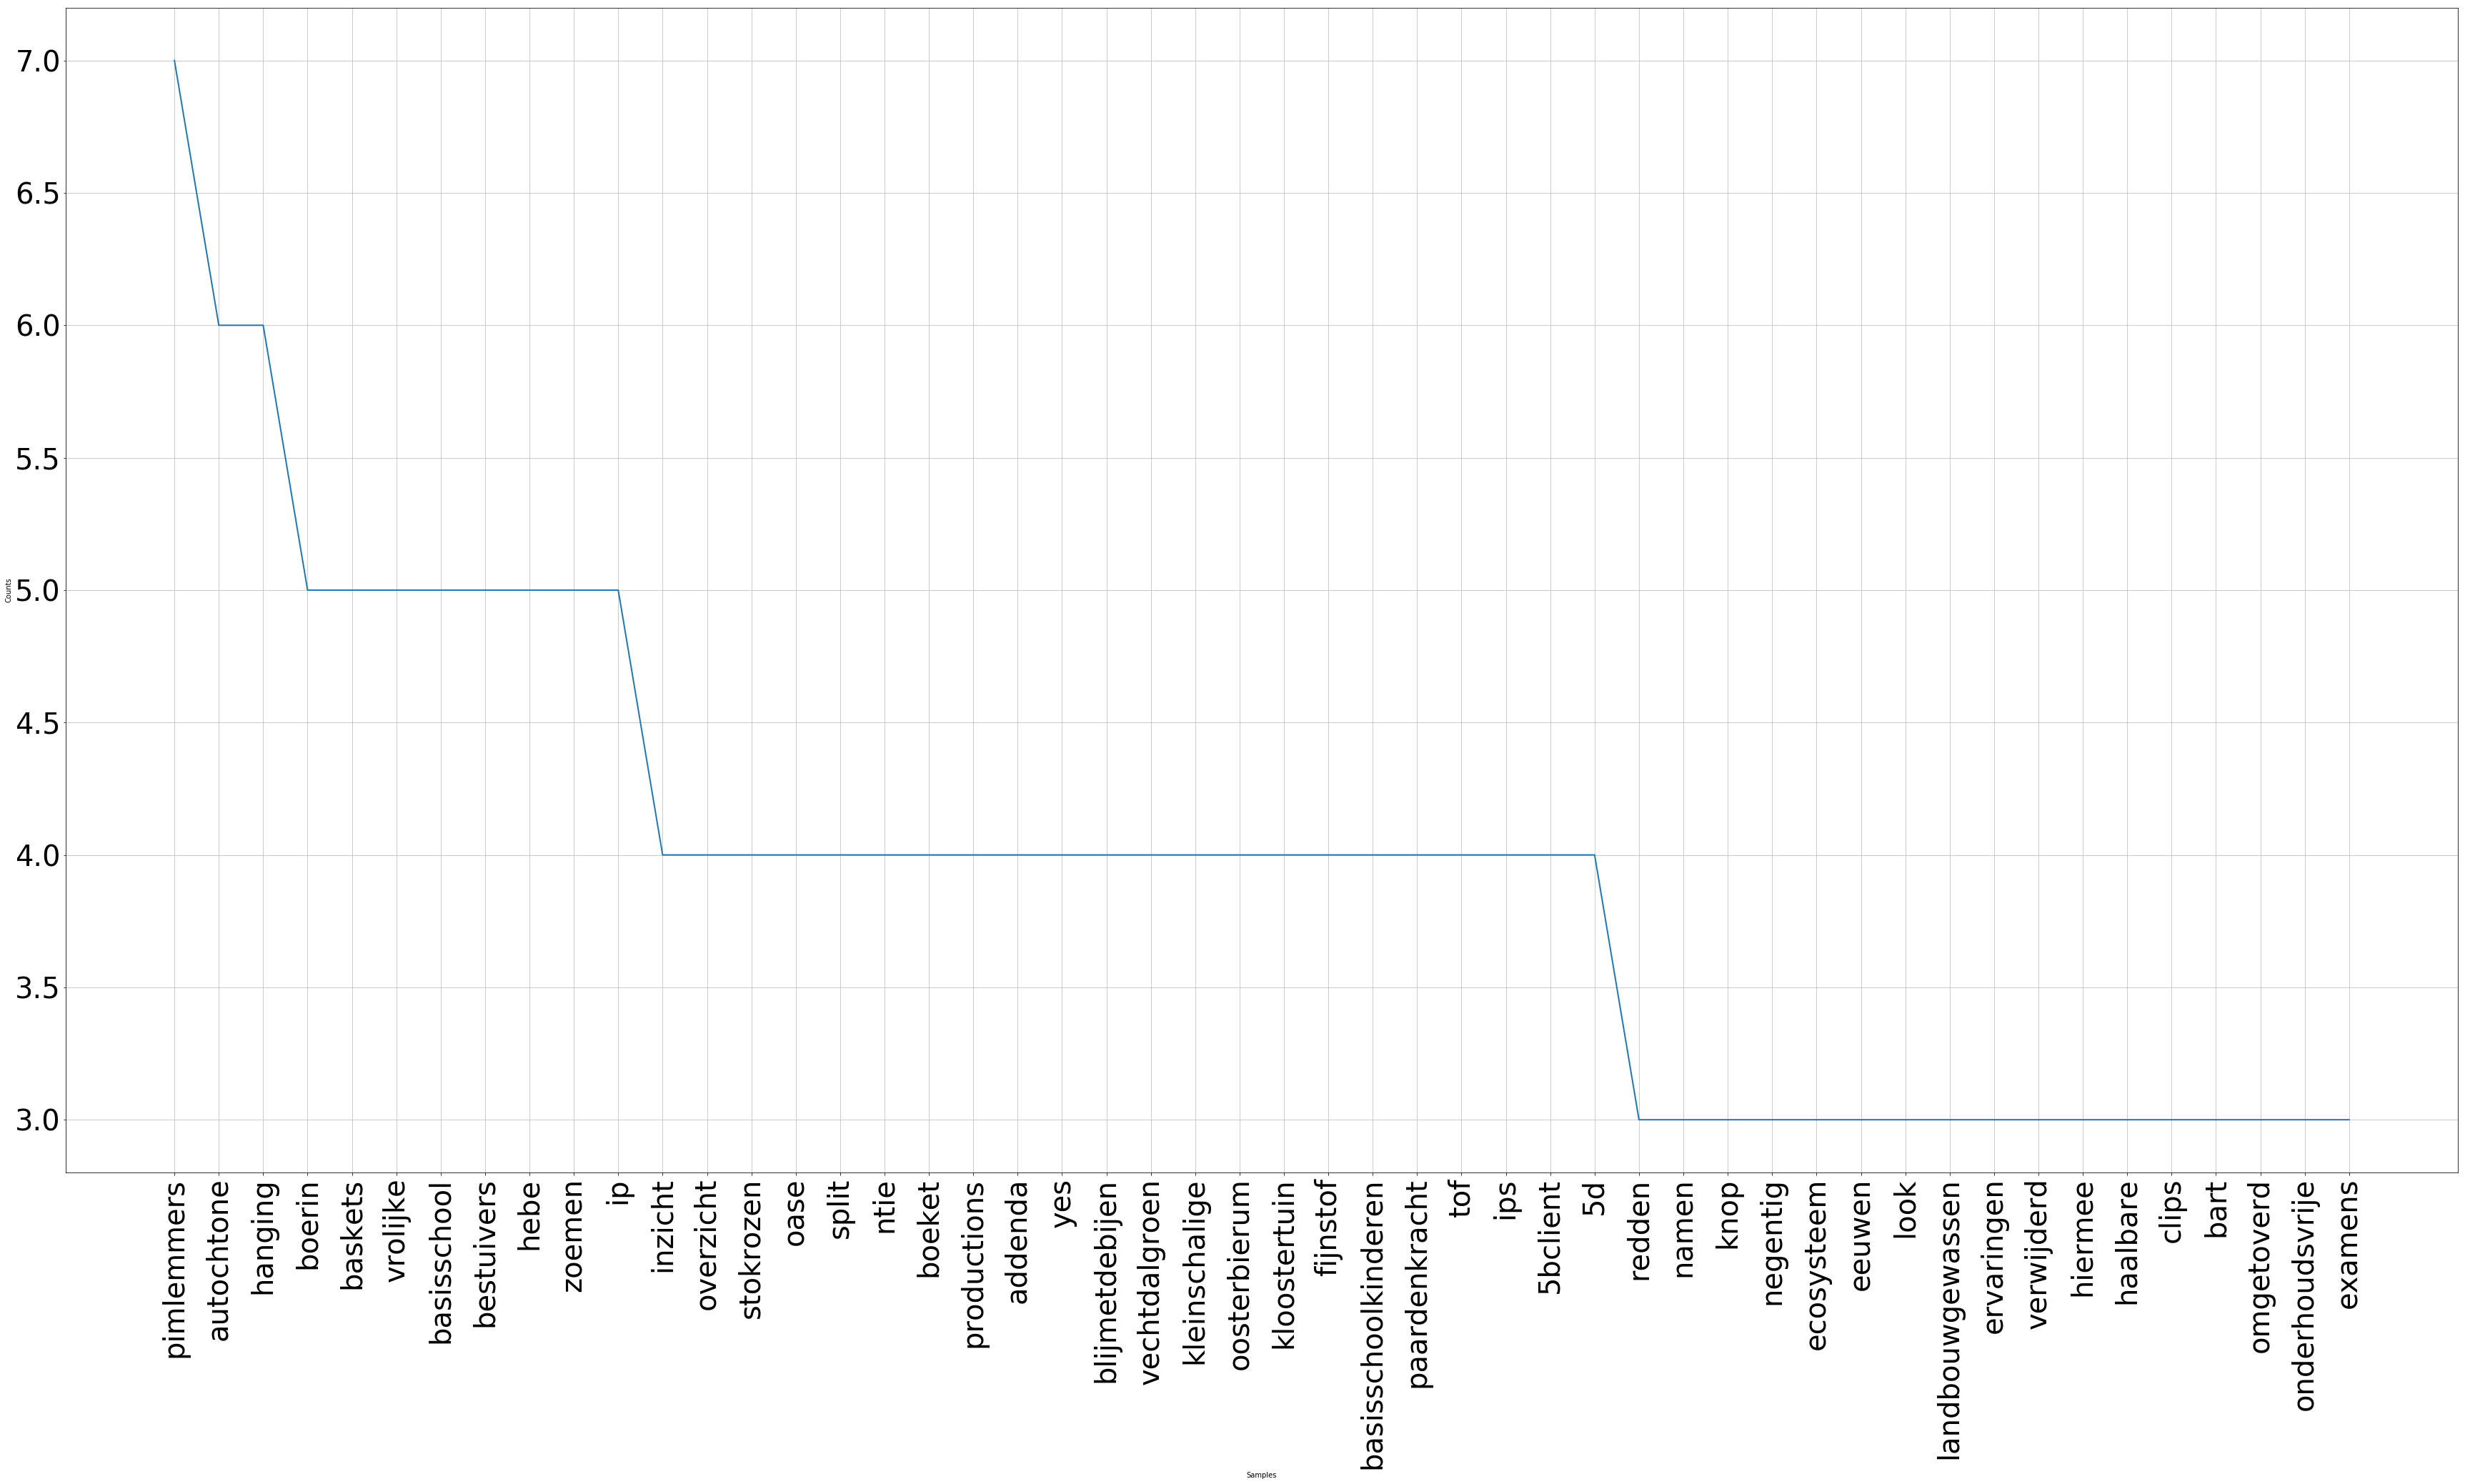

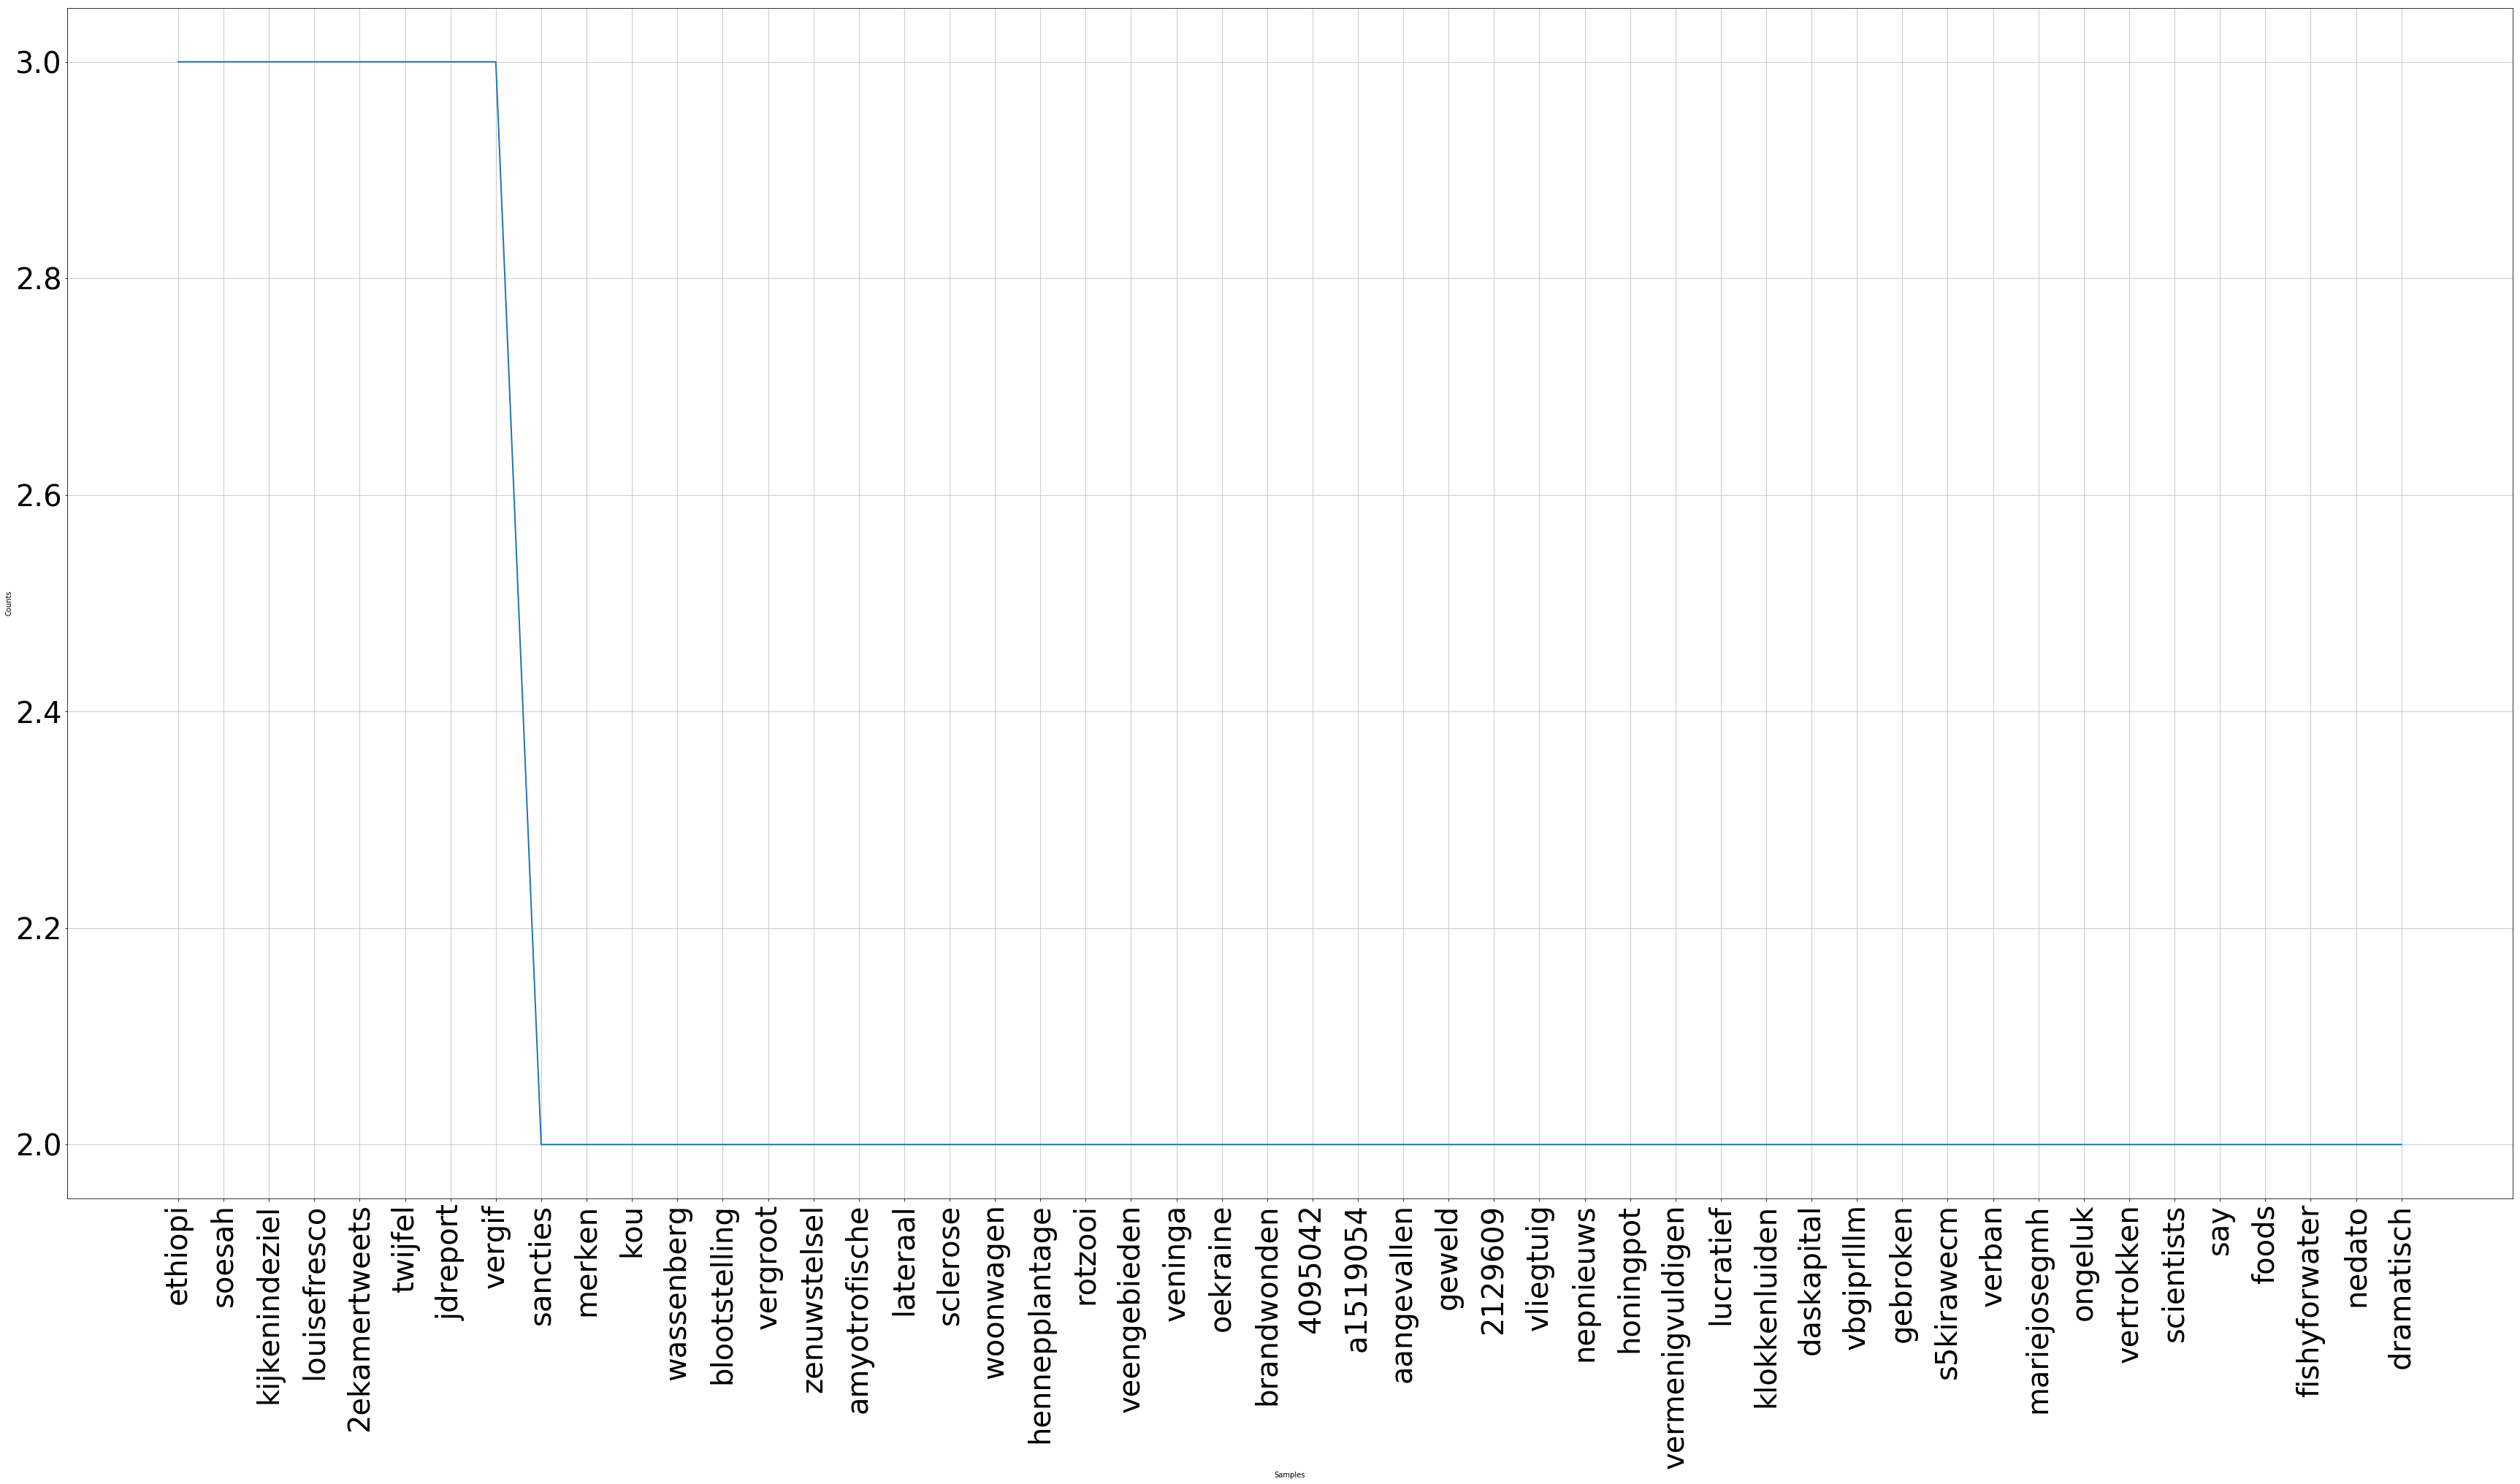

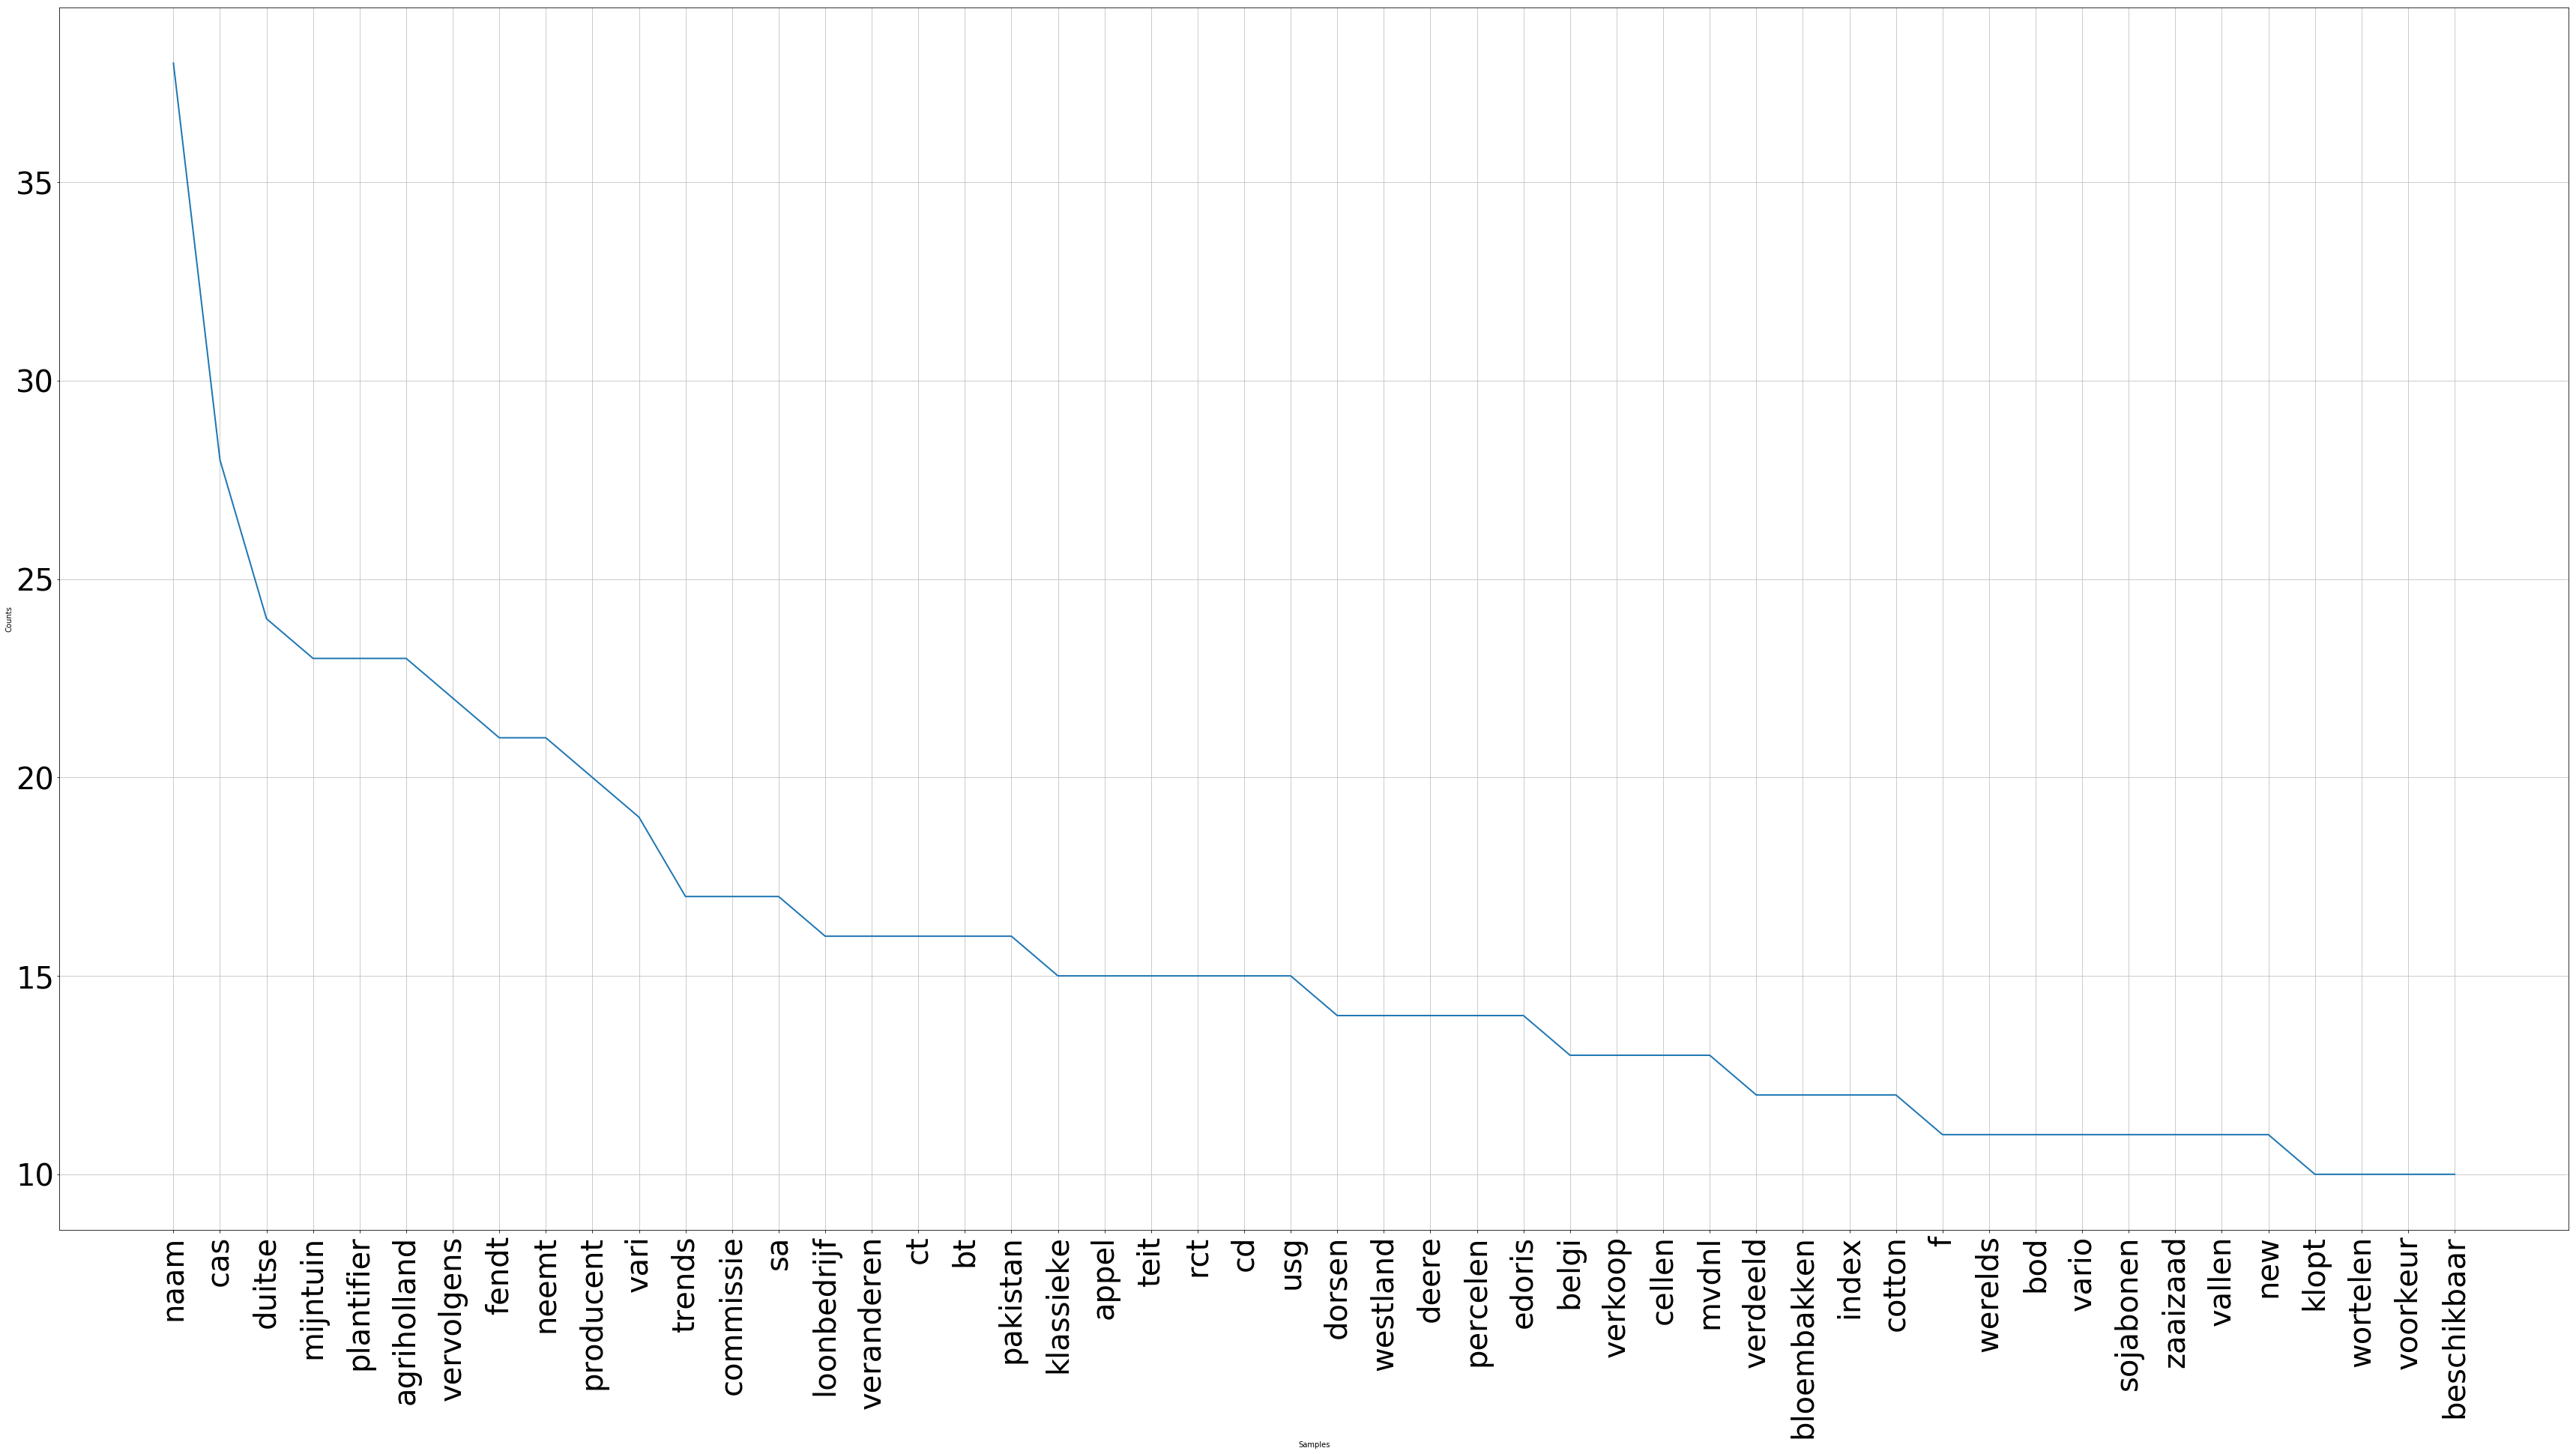

In [173]:
# Words distribution plot for each sentiment for not intersected words
# Define requency count of the words for each sentiment 
freqDist_positive = FreqDist(unic_positive)
freqDist_negative = FreqDist(unic_negative)
freqDist_neutral = FreqDist(unic_neutral)
# Draw plots
freqDist_positive.plot(50)
freqDist_negative.plot(50)
freqDist_neutral.plot(50)

##### Conclusion:
#####      Not intersected words for each sentiment might be featured, but we do not have enough data. For example, for the negative sentiment, the most frequent not intersected word repeats only 3 times. For better prediction, we need more data, especially for negative and positive sentiment. For neutral the situation is better a bit.

##### We can also use n-grams for the prediction

# (2) Feature Extraction

### 2.1 - Use a Sklearns Count Vectorizer to transfer your text into a vector that represents the text into a table of word counts with columns representing the words and each row representing a specific post and the number of times it uses each word appears in the post

In [176]:
# Use CountVectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
vectorizer = CountVectorizer(lowercase=True,tokenizer = token.tokenize)
# Getting Sparce matrix 
X = vectorizer.fit_transform(df['content'])
s_matrix = pd.SparseDataFrame(vectorizer.fit_transform(df['content']),
                        columns=vectorizer.get_feature_names(),
                        index=df.index)

### 2.2 - Show this table in your ipython notebook and discuss about anything you find interesting

In [177]:
# Define the spape of the matrix
s_matrix.shape

(3166, 16249)

In [183]:
# Replace Nan values by "0"
s_matrix.fillna(0, inplace=True)

We have 16249 columns. It's unreal to display this table on the screen. 
So, we can display some values from the table.

In [184]:
s_matrix.iloc[:30, -20:]

,zweigelt,zwembaden,zwemlessen,zwerfvuil,zwerm,zwevende,zwhuznxh2k,zwiebel,zwijndrecht,zwijnenburg,zwink,zwitserland,zwitserse,zwolle,zwolse,zy0vflbmos,zyklon,zz2dnwlj5s,zzpkiest,zzt1aeauy2c
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# (3) Modeling - Model creation and evaluation

### 3.1- Train any of the classifiers to learn to predict sentiment and give a justification for why you choose it

I selected logistic regression because the algorithm uses for classification issues and give us the probability for each class.
The best idea is using a couple of algorithms. For example, I think that we can also use the Neural Network and XGboost. After can be selected the best algorithm.

In [185]:
# Test and Train splitting for the modeling
X_train, X_test, y_train, y_test = train_test_split(
    s_matrix, df['sentiment'], test_size=0.3, random_state=123)

In [186]:
model = LogisticRegression()
result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 3.2 - Evaluate the performance of your model (i.e. accuracy, precision, and recall) of your trained model

In [190]:
print('Accuracy:{}'.format(round(accuracy_score(y_test, y_pred),3)), 
      '\nPrecision:{}'.format(round(precision_score(y_test, y_pred, average='macro'),3)),
      '\nRecall:{}'.format(round(recall_score(y_test, y_pred, average='macro'),3)))

Accuracy:0.716 
Precision:0.613 
Recall:0.453


So, Precision and recall are not too good. Accuracy is better, it means that we get the wrong prediction in 3 of 10 reviews. It should be increased too 

# (5) List and describe what you will do to improve the models performance

There are a couple of approaches:
- N-grams. I used 1,2 and 3 words on my local machine, but it did not give good improvement. 
- Improve the algorithm parameters (penalty and C parameter). It can increase metrics a bit. 
- Test other algorithms. I think that we should test the XBgoost and Neural Network. Those might give better results
- Get more data. We have a little number of reviews, especially for negative and positive sentiment. From 18 000 reviews were used 3166. So, we can mark up reviews without the sentiment or get new reviews. 